Step $3$: we want to compute some quantities on the ROI image. In particular:
- we want to compute the $X$ dimension, which is the minimum width of a barcode bar;
- we want to compute the minimum length of a barcode bar.

We will use these two quantities for cropping the ROI image, for obtained the final refined ROI image.

The idea is to compute both these quantities with a single pass over the ROI image. Basically, we draw an horizontal line in the exact middle of the ROI image, and then we scan the pixels in this line. Then, we expand upward and downward for computing the minimum height of a bar, both upward and downward. So, we will actually compute $3$ quantities: `X`, `min_half_height_up`, and `min_half_height_down`.

In this single pass, we will also compute two other quantities: 
- `first_bar_x`, which is the x coordinate of the first pixel of the first bar;
- `last_bar_x`, which is the x coordinate of the last pixel of the last bar.

In [100]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math

In [101]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

In [102]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [103]:
image_path = f'../images/{images_paths[26]}'

(1024, 1280, 3)


Text(0.5, 1.0, 'Original image')

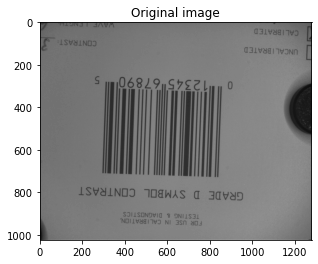

In [104]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[296., 246.],
       [873., 265.],
       [280., 726.],
       [857., 745.]], dtype=float32)

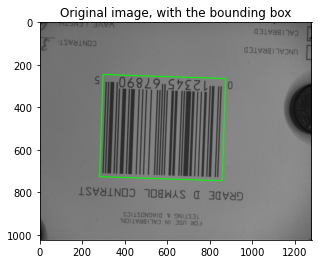

In [105]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

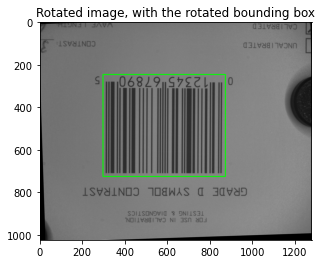

In [106]:
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=True)

In [107]:
image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=True)

In [108]:
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

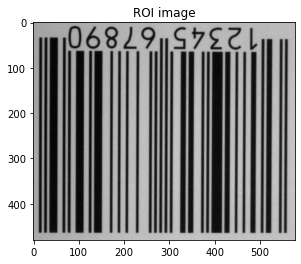

In [109]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

## THRESHOLDING OF THE IMAGE
First of all, we threshold the ROI image. Otsu's alogirthm.

Text(0.5, 1.0, 'Thresholded ROI image')

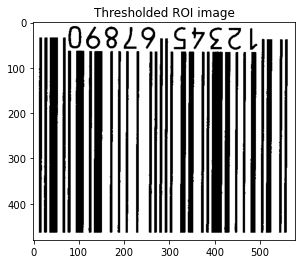

In [110]:
_ ,ROI_thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(ROI_thresh, 'gray')
plt.title('Thresholded ROI image')

## ALGORITHM: FIRST IDEA

We define `half_height` as the middle along the height.

We scan each pixel $i$ along this horizontal line.
- If the pixel is white, we continue to the next pixel.
- If the pixel is black, then it is the first pixel belonging to a new bar. 
    - We compute the width of this bar as the number of adjacent black pixels til the next white pixel. 
    - Then, we go up along the vertical line $i$, till finding the first white pixel: in this way, we compute `min_half_height_up` of this current bar. At the same time, we compute `min_half_height_down` of this current bar.
    
On the whole, we compute $X$, `min_half_height_up` and `min_half_height_down` by taking the minimum quantities along the whole 

In [111]:
half_height = int(bb_height/2)
half_height

240

In [82]:
# INIZIALIZATION
first_bar_found = False  # Flag tellying us if we have already seen a barcode bar
X = bb_width
min_half_height_up = half_height
min_half_height_down = half_height
i = 0  # Index for iterating over the pixels

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        print('W', end='')
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
    print('B', end='')
    
    # First time we see a barcode bar
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i_end]==0:
        print('B', end='')
        X_curr += 1
        i_end += 1
    # If the width of this current bar is less than `X`, we update `X`
    if X_curr<X:
        X = X_curr
       
    # Now we search upward and downward along the vertical line 'i'.
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while ROI_thresh[j_up, i]==0 or ROI_thresh[j_down, i]==0:
        if ROI_thresh[j_up, i]==0:
            j_up -= 1
            min_half_height_up_curr += 1
        if ROI_thresh[j_down, i]==0:
            j_down += 1
            min_half_height_down_curr += 1
            
    if min_half_height_up_curr<min_half_height_up:
        #print('up',i,min_half_height_up_curr)
        min_half_height_up = min_half_height_up_curr
    if min_half_height_down_curr<min_half_height_down:
        #print('down',i,min_half_height_down_curr)
        min_half_height_down = min_half_height_down_curr
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end
    
last_bar_x = i_end - 1

WWWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWWWBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWWBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWWWWWWWWWWWW

In [83]:
print(len('WWWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWWBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBWWWWWWBBBBBBWWWWWWWWWWWWWWWWW'))
bb_width

577


577

In [84]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 559
X: 5
min_half_height_up: 2
min_half_height_down: 223


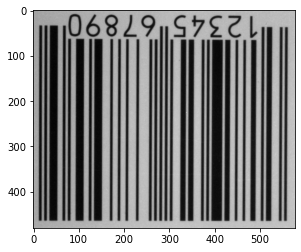

In [85]:
plt.imshow(roi_image, 'gray')

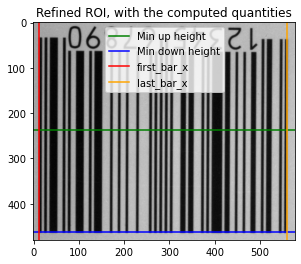

In [86]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

## PROBLEM

`min_half_height_up` is clearly not correct: they are far too small... Why?

Because the barcode bars are not perfectly vertical!!! There can be errors, namely on the contours: degradated contours. ("Bordi smangiati"). They are more this kind of errors, than holes or other things. Even if, of course, it can also happen to have wrong black/white pixels.

So, we can't just go upward and downward along the vertical line passing through the first pixel `i` of that bar. We need to do a more sophisticated thing.

This problem could affect the computation of `min_half_height_up` and `min_half_height_down`, but  also the computation of the $X$ dimension, since the holes can be present also in the horizontal line in the middle of the ROI image.

For solving this problem, two different solutions are proposed.

## SOLUTION 1

We modify the previous algorithm in the following way.

We are in a current bar, with starting pixel `i`, last pixel `i_end` and width `X_curr`. For now, we have just scanned the middle horizontal line, we aren't gone upward/downward yet. The idea is to, while exploring upward/downward, dynamically modify the quantities `i`,`i_end`,`X_curr`. For instance, if we are in the vertical upward level `j_up` and we find that there is another black pixel after `i_end`, we increment `i_end` and `X_curr` by $1$. The same also if we find a black pixel before the pixel `i`. This exact same reasoning is applied at the same time downward, on `j_down`. At each step of the vertical exploration, we are in certain current levels `j_up` and `j_down`, and both of them can modify the current `i`,`i_end`,`X_curr`: we keep the minimum `i`, the maximum `i_end` and the maximum `X_curr`.

We stop the exploration upward, i.e. we find `min_half_height_up_curr`, when we find a level `j_up` with all the `X_curr` pixels as white. The same for `min_half_height_up_curr` and `j_down`.

In [87]:
# INIZIALIZATION
first_bar_found = False  # Flag tellying us if we have already seen a barcode bar
X = bb_width
min_half_height_up = half_height
min_half_height_down = half_height
i = 0  # Index for iterating over the pixels

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
    
    # First time we see a barcode bar
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i_end]==0:
        X_curr += 1
        i_end += 1
       
    # Now we search vertically upward and downward along that bar
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Flag saying whether the max up height has been reached or not
    up_reached = False
    # Flag saying whether the max down height has been reached or not
    down_reached = False
    
    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while not up_reached or not down_reached:
        """X_tmp_up = X_curr
        X_tmp_bottom = X_curr

        if not up_reached:
            while thresh[j_up, i-1]==0:  #######
                X_tmp_up += 1
                i -= 1 
            while thresh[j_up, j]==0:
                X_tmp_up += 1
                j +=1 
        if not bottom_reached:
            while thresh[j_bottom, i-1]==0:  ##########
                X_tmp_bottom += 1
                i -= 1 
            while thresh[j_bottom, j]==0:
                X_tmp_bottom += 1
                j +=1 
        X_curr = max([X_tmp_up,X_tmp_bottom])"""
        
        #print(11)
        #print(up_reached,down_reached)
        
        # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities
        
        # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
        X_inc_left_up = 0
        # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means before the index `i_end`.
        X_inc_right_up = 0
        # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
        X_inc_left_down = 0
        # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means before the index `i_end`.
        X_inc_right_down = 0

        if not up_reached:  # Vertical level `j_up`
            while ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                #print(8)
                X_inc_left_up += 1
                i -= 1 
            while ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_up += 1
                i_end +=1 
        if not down_reached:  # Vertical level `j_down`
            while ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                X_inc_left_down += 1
                i -= 1 
            while ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_down += 1
                i_end +=1 
        
        # Update `X_curr`, adding the maximum, both left and right.
        X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<=0 or np.all(ROI_thresh[j_up, i:i_end]==255)
        """if X_curr==1 and not up_reached :
           foreground_perc_points = (thresh[0:j_up, i]==0).sum()/thresh[0:j_up, i].shape[0]
           #print('Up', foreground_perc_points)
           up_reached = j_up<=0 or foreground_perc_points<0.1"""
        # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1

        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>=bb_height-1 or np.all(ROI_thresh[j_down, i:i_end]==255)
        """if X_curr==1 and not bottom_reached:
           #bottom_reached = j_bottom>=bb_height-1 or np.all(thresh[j_bottom+1:min([bb_height-1,j_bottom+4]), i]==255)
           foreground_perc_points = (thresh[j_bottom:, i]==0).sum()/thresh[j_bottom:, i].shape[0]
           #print('Bottom', foreground_perc_points)
           bottom_reached = j_bottom>=bb_height-1 or foreground_perc_points<0.1"""
        if not down_reached:
            j_down += 1
            min_half_height_down_curr += 1
            
    # Now we have computed the actual `X_curr`
            
    # If the width of this current bar is less than `X`, we update `X`
    if X_curr<X:
        X = X_curr
            
    if min_half_height_up_curr<min_half_height_up:
        #print('up',i,min_half_height_up_curr)
        min_half_height_up = min_half_height_up_curr
    if min_half_height_down_curr<min_half_height_down:
        #print('down',i,min_half_height_down_curr)
        min_half_height_down = min_half_height_down_curr
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end
    
last_bar_x = i_end - 1

In [88]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 560
X: 7
min_half_height_up: 174
min_half_height_down: 224


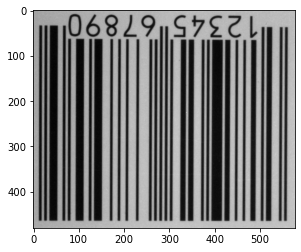

In [89]:
plt.imshow(roi_image, 'gray')

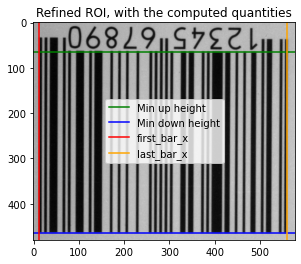

In [90]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

### Limitations
1. A clear limitation of this approach is that we are considering, as possible errors, only white pixels. Only errors: white pixels which should be black (i.e. they should belong to a bar). However, as errors, there could be also black pixels: black pixels which should be white (i.e. they should be of the background). This implies that we are overestimating the widths of the bars, taking the biggest possible size, even if it could be not perfectly correct.
2. Another limitation is about the detection of the end of a bar vertically, i.e. the computation of `min_half_height_up_curr` and `min_half_height_down_curr`. Basically, we stop when we find a vertical level (either `j_up` or `j_down`) which have all `X_curr` pixels as white. However, it can happen that a single white pixel is wrongly black, therefore we don't detect the end of the bar. (As said before, also black pixels can be wrong). Therefore, we may overestimate the height of a bar.

## SOLUTION 2
We want to address the second limitation just described, about the computation of the height of the bars.

While exploring vertically and we are in a certain level, either `j_up` or `j_down`, we stop when the number of black pixels in that level is less than the $25$% of `X_curr`: basically, the number of actual black pixels among the pixels that should be black (i.e. `X_curr`) is less than $25$%. In other words, $75$% of white pixels among `X_curr`.

With respect to before, we are more flexible: we are not asking anymore that all pixels are white, but we are allowing some bad black pixels to be present in our border. In this way, we should be more precise in the computation of the heights of the bar.

In [112]:
# INIZIALIZATION
first_bar_found = False  # Flag tellying us if we have already seen a barcode bar
X = bb_width
min_half_height_up = half_height
min_half_height_down = half_height
i = 0  # Index for iterating over the pixels

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
    
    # First time we see a barcode bar
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    # Width of this current bar
    X_curr = 1    
    # Index representing the last pixel in this current bar
    i_end = i+1
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i_end]==0:
        X_curr += 1
        i_end += 1
       
    # Now we search vertically upward and downward along that bar
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Flag saying whether the max up height has been reached or not
    up_reached = False
    # Flag saying whether the max down height has been reached or not
    down_reached = False
    
    #print(7)

    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while not up_reached or not down_reached:
        
        # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities
        
        # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
        X_inc_left_up = 0
        # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means before the index `i_end`.
        X_inc_right_up = 0
        # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
        X_inc_left_down = 0
        # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means before the index `i_end`.
        X_inc_right_down = 0

        if not up_reached:  # Vertical level `j_up`
            while ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                #print(8)
                X_inc_left_up += 1
                i -= 1 
            while ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_up += 1
                i_end +=1 
        if not down_reached:  # Vertical level `j_down`
            while ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                X_inc_left_down += 1
                i -= 1 
            while ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                X_inc_right_down += 1
                i_end +=1 
        
        # Update `X_curr`, adding the maximum, both left and right.
        X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<=0 or ((ROI_thresh[j_up, i:i_end]==0).sum()/X_curr)<0.25
        # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1

        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>=bb_height-1 or ((ROI_thresh[j_down, i:i_end]==0).sum()/X_curr)<0.25
        if not down_reached:
            j_down += 1
            min_half_height_down_curr += 1
            
    # Now we have computed the actual `X_curr`
            
    # If the width of this current bar is less than `X`, we update `X`
    if X_curr<X:
        X = X_curr
            
    if min_half_height_up_curr<min_half_height_up:
        #print('up',i,min_half_height_up_curr)
        min_half_height_up = min_half_height_up_curr
    if min_half_height_down_curr<min_half_height_down:
        #print('down',i,min_half_height_down_curr)
        min_half_height_down = min_half_height_down_curr
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_end
    
last_bar_x = i_end - 1

In [113]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 560
X: 7
min_half_height_up: 175
min_half_height_down: 224


`min_half_height_down` is $1$ less than before

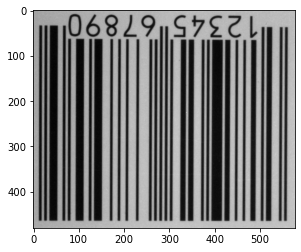

In [93]:
plt.imshow(roi_image, 'gray')

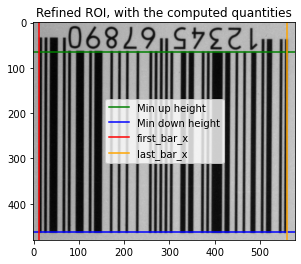

In [94]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

## SOLUTION 3
With solution $3$, we have addressed the limitation $2$ described before: now, we want to address limitation $1$.

The idea is that we compute the width of a bar as the mean of the widths encountered in the vertical exploration. While exploring vertically, upward and downward, we dynamically update `X_curr` as the mean of the already encountered widths of that bar.

The detection of the vertical and, both upward and downward, is the same seen in solution $2$.

In [124]:
# INIZIALIZATION
first_bar_found = False  # Flag tellying us if we have already seen a barcode bar
X = bb_width
min_half_height_up = half_height
min_half_height_down = half_height
i = 0  # Index for iterating over the pixels

# CYCLE
# We scan each pixel along the horizontal line in the exact middle of the ROI image
while i<bb_width:
    
    # White pixel: we go to the next pixel
    if ROI_thresh[half_height, i]==255:
        i += 1
        continue
    
    # Black pixel
    # 'i' is the first pixel in this current barcode bar
    
    # First time we see a barcode bar
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    # Width of this current bar
    X_curr = 1    
    
    # We go right, till finding a white pixel.
    # In this way, we compute the width of this current bar.
    while ROI_thresh[half_height, i+X_curr]==0:
        X_curr += 1
        
    i_next = i+X_curr
       
    # Now we search vertically upward and downward along that bar
    # Index for goind upward.
    j_up = half_height-1
    # Index for goind downward.
    j_down = half_height+1
    # Half upward height of this current bar
    min_half_height_up_curr = 1
    # Half downard height of this current bar
    min_half_height_down_curr = 1
    
    # Number of vertical levels explored so far
    l = 1
    i_med = int(i+X_curr/2)
    
    # Flag saying whether the max up height has been reached or not
    up_reached = False
    # Flag saying whether the max down height has been reached or not
    down_reached = False
    
    print(i, i_med, X_curr)

    # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
    # `min_half_height_down_curr`
    while not up_reached or not down_reached:
        if not up_reached:
            X_curr_tmp_up = 0
            ii = 1
            i_tmp_up = i_med 
            while ROI_thresh[j_up, i_med-ii]==0 or ROI_thresh[j_up, i_med+ii]==0:
                if ROI_thresh[j_up, i_med-ii]==0:
                    X_curr_tmp_up += 1
                    i_tmp_up -= 1
                if ROI_thresh[j_up, i_med+ii]==0:
                    X_curr_tmp_up += 1
                ii += 1                
            X_curr = (l*X_curr + X_curr_tmp_up)/(l+1)
            i = (l*i + i_tmp_up)/(l+1)
            l = l+1
                
        if not down_reached:
            X_curr_tmp_down = 0
            ii = 1
            i_tmp_down = i_med 
            while ROI_thresh[j_down, i_med-ii]==0 or ROI_thresh[j_down, i_med+ii]==0:
                if ROI_thresh[j_down, i_med-ii]==0:
                    X_curr_tmp_down += 1
                    i_tmp_down -= 1
                if ROI_thresh[j_down, i_med+ii]==0:
                    X_curr_tmp_down += 1
                ii += 1
            X_curr = (l*X_curr + X_curr_tmp_down)/(l+1)
            i = (l*i + i_tmp_down)/(l+1)
            l = l+1
                       
        i_int = int(math.floor(i))
        i_end = int(math.floor(i+X_curr))
        i_med = int(i+X_curr/2)

        # Understand if we have reached the up-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
        # of course, if we are outside the image.
        up_reached = up_reached or j_up<=0 or ((ROI_thresh[j_up, i_int:i_end]==0).sum()/X_curr)<0.25
        # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1

        # Understand if we have reached the down-top of this current bar.
        # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
        # of course, if we are outside the image.
        down_reached = down_reached or j_down>=bb_height-1 or ((ROI_thresh[j_down, i_int:i_end]==0).sum()/X_curr)<0.25
        if not down_reached:
            j_down += 1
            min_half_height_down_curr += 1
            
    i = int(math.floor(i))
    X_curr = int(math.floor(X_curr))
            
    # Now we have computed the actual `X_curr`
            
    # If the width of this current bar is less than `X`, we update `X`
    if X_curr<X:
        X = X_curr
            
    if min_half_height_up_curr<min_half_height_up:
        #print('up',i,min_half_height_up_curr)
        min_half_height_up = min_half_height_up_curr
    if min_half_height_down_curr<min_half_height_down:
        #print('down',i,min_half_height_down_curr)
        min_half_height_down = min_half_height_down_curr
        
    # We update `i`: we pass to the white pixel right after the current bar
    i = i_next
    
last_bar_x = i_end - 1

13 16 7
25 28 6
36 45 18
65 68 7
77 80 6
94 103 18
123 126 6
135 144 18
170 173 6
187 190 6
205 207 5
228 230 5
256 259 6
267 270 6
279 282 6
290 293 7
302 305 6
325 331 12
342 348 12
371 374 6
382 385 6
394 405 23
422 428 12
445 448 6
463 465 5
480 485 11
503 506 6
514 520 12
543 545 5
554 557 6


In [125]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 557
X: 4
min_half_height_up: 175
min_half_height_down: 224


In [113]:
print(first_bar_found)

print('first_bar_x:', first_bar_x)

print('last_bar_x:', last_bar_x)

print('X:', X)

print('min_half_height_up:', min_half_height_up)

print('min_half_height_down:', min_half_height_down)

True
first_bar_x: 13
last_bar_x: 560
X: 7
min_half_height_up: 175
min_half_height_down: 224


`min_half_height_down` is $1$ less than before

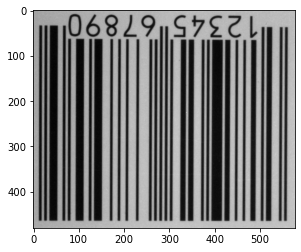

In [126]:
plt.imshow(roi_image, 'gray')

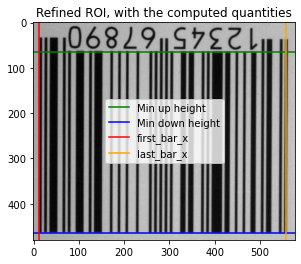

In [127]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
plt.axvline(first_bar_x, c='red', label='first_bar_x')
plt.axvline(last_bar_x, c='orange', label='last_bar_x')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

In [47]:
half_height+min_half_height_down

244

Text(0.5, 1.0, 'Thresholded ROI image')

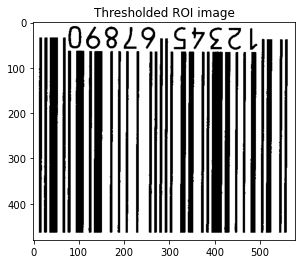

In [60]:

plt.figure()
plt.imshow(ROI_thresh, 'gray')
plt.title('Thresholded ROI image')

Text(0.5, 1.0, 'Thresholded ROI image')

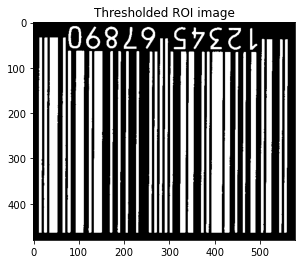

In [61]:
thresh = 255 - ROI_thresh
plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Thresholded ROI image')

In [63]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

Text(0.5, 1.0, 'Thresholded ROI image')

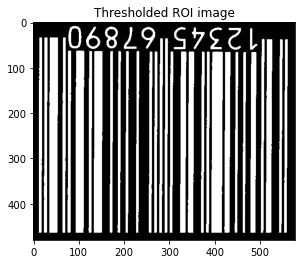

In [64]:
plt.figure()
plt.imshow(closed, 'gray')
plt.title('Thresholded ROI image')

Text(0.5, 1.0, 'Thresholded ROI image')

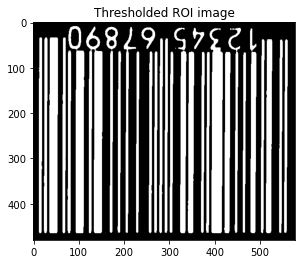

In [65]:
blurred = cv2.blur(roi_image, (1, 10))
_ ,ROI_thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = 255-ROI_thresh
plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Thresholded ROI image')